# Coursework for MRI reconstruction (Autumn 2019)

In this tutorial, we provide the data loader to read and process the MRI data in order to ease the difficulty of training your network. By providing this, we hope you focus more on methodology development. Please feel free to change it to suit what you need.

In [2]:
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt

In [3]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [4]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [5]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
        
    return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

In [6]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list    

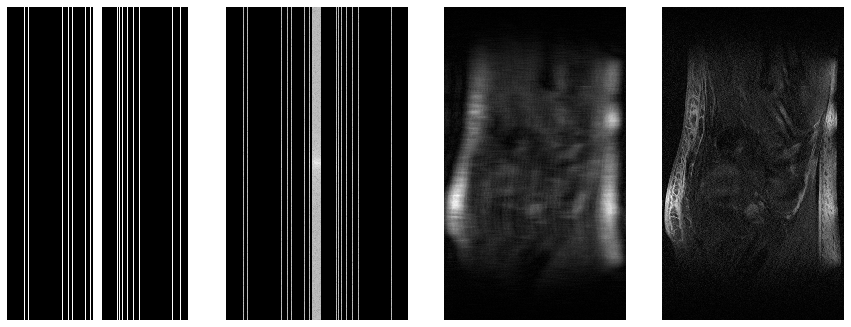

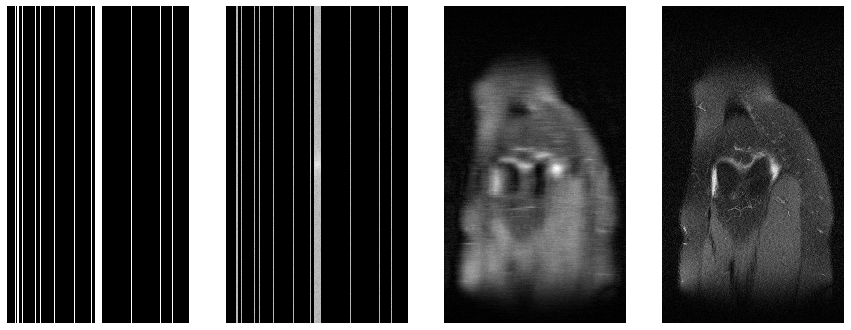

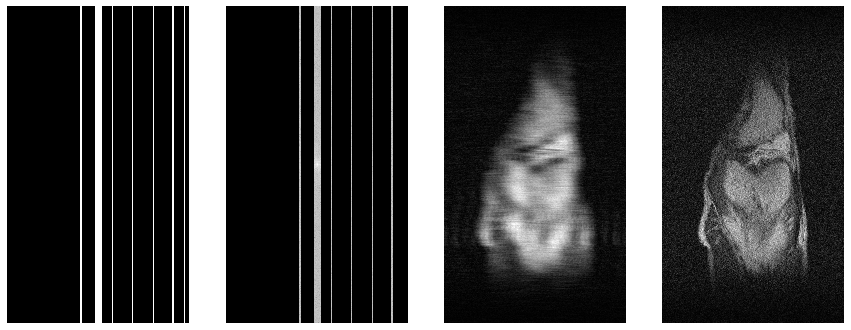

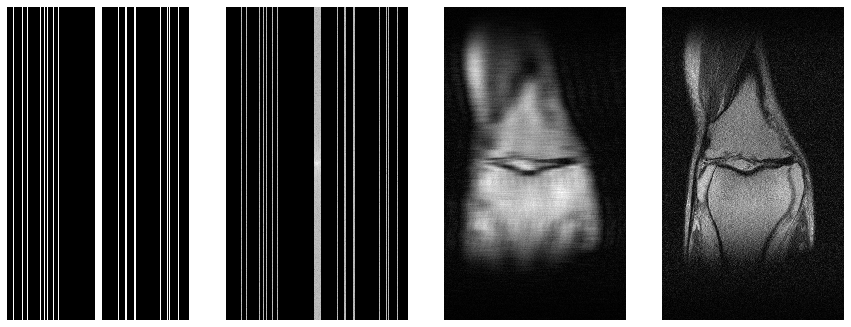

In [15]:
if __name__ == '__main__':
    
    data_path_train = '/home/kevinxu/Documents/NC2019MRI/train'
    data_path_val = '/home/kevinxu/Documents/NC2019MRI/train'
    data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.

    acc = 8
    cen_fract = 0.04
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
    # create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    for iteration, sample in enumerate(train_loader):
        
        img_gt, img_und, rawdata_und, masks, norm = sample
         
        # stack different slices into a volume for visualisation
        A = masks[...,0].squeeze()
        B = torch.log(T.complex_abs(rawdata_und) + 1e-9).squeeze()
        C = T.complex_abs(img_und).squeeze()
        D = T.complex_abs(img_gt).squeeze()
        all_imgs = torch.stack([A,B,C,D], dim=0)

        # from left to right: mask, masked kspace, undersampled image, ground truth
        show_slices(all_imgs, [0, 1, 2, 3], cmap='gray')
        plt.pause(1)

        if iteration >= 3: break  # show 4 random slices

In [13]:
A

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [10]:
B

tensor([[-20.7233, -20.7233, -20.7233,  ..., -20.7233, -20.7233, -20.7233],
        [-20.7233, -20.7233, -20.7233,  ..., -20.7233, -20.7233, -20.7233],
        [-20.7233, -20.7233, -20.7233,  ..., -20.7233, -20.7233, -20.7233],
        ...,
        [-20.7233, -20.7233, -20.7233,  ..., -20.7233, -20.7233, -20.7233],
        [-20.7233, -20.7233, -20.7233,  ..., -20.7233, -20.7233, -20.7233],
        [-20.7233, -20.7233, -20.7233,  ..., -20.7233, -20.7233, -20.7233]])

In [11]:
C

tensor([[0.0030, 0.0013, 0.0040,  ..., 0.0042, 0.0028, 0.0013],
        [0.0037, 0.0028, 0.0028,  ..., 0.0022, 0.0037, 0.0044],
        [0.0013, 0.0020, 0.0010,  ..., 0.0011, 0.0015, 0.0013],
        ...,
        [0.0009, 0.0023, 0.0029,  ..., 0.0024, 0.0049, 0.0026],
        [0.0033, 0.0014, 0.0030,  ..., 0.0047, 0.0029, 0.0032],
        [0.0023, 0.0014, 0.0032,  ..., 0.0027, 0.0022, 0.0024]])

In [12]:
D

tensor([[0.0082, 0.0082, 0.0014,  ..., 0.0121, 0.0049, 0.0070],
        [0.0096, 0.0086, 0.0036,  ..., 0.0032, 0.0072, 0.0090],
        [0.0026, 0.0182, 0.0055,  ..., 0.0014, 0.0057, 0.0092],
        ...,
        [0.0066, 0.0033, 0.0140,  ..., 0.0072, 0.0059, 0.0038],
        [0.0172, 0.0046, 0.0067,  ..., 0.0109, 0.0042, 0.0030],
        [0.0082, 0.0040, 0.0102,  ..., 0.0167, 0.0109, 0.0041]])